# **Importing Libraries & Dataset**

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
churn_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **Data Audit**






In [153]:
# Dimension of churn data
churn_data.shape

(7043, 21)

In [154]:
# Missing Value Counts (Column-wise)
churn_data.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [155]:
# Checking all data types
churn_data.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [156]:
# Checking for duplicates
churn_data.duplicated().sum()

np.int64(0)

In [157]:
# Percentage of Churners V/S. Non-Churners
churn_data['Churn'].value_counts(normalize=True)

,proportion
Churn,
No,0.73463
Yes,0.26537


**STEP 1 — Data Audit Conclusion**




1.   The dataset contains 7,043 customers and 21 features with no missing values or duplicate records, indicating strong data quality.

2. The target variable Churn is moderately imbalanced, with ~26.5% churners, which justifies using recall-focused evaluation metrics and class-imbalance–aware modeling techniques.

3. The data includes a mix of categorical service attributes and numeric account variables, making it suitable for both interpretable and ensemble models.

# **Targeted EDA**



> *What characteristics clearly separate churners from non-churners?*



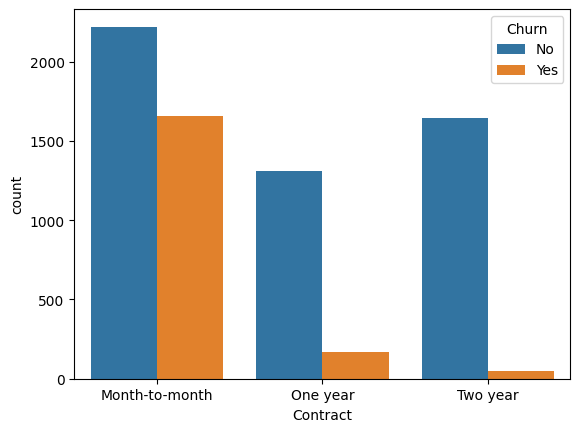

In [158]:
# Contract Type v/s. Churn
sns.countplot(x='Contract', hue='Churn', data=churn_data)
plt.show()

/tmp/ipython-input-240039585.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_data.groupby('tenure_bucket')['Churn']


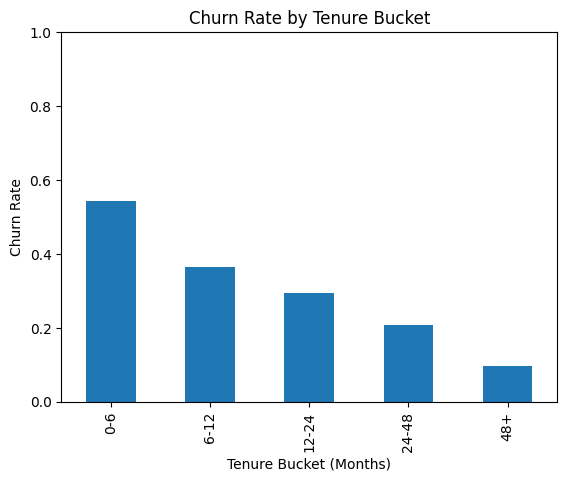

In [159]:
# Tenure v/s. Churn
# ---- Tenure Bucketing ----
bins = [0, 6, 12, 24, 48, 100]
labels = ['0-6', '6-12', '12-24', '24-48', '48+']

churn_data['tenure_bucket'] = pd.cut(churn_data['tenure'], bins=bins, labels=labels, right=False)

# ---- Churn Rate Calculation ----
churn_rate = (
    churn_data.groupby('tenure_bucket')['Churn']
              .apply(lambda x: (x == 'Yes').mean())
)

# ---- Plot ----
plt.figure()
churn_rate.plot(kind='bar')
plt.xlabel('Tenure Bucket (Months)')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Tenure Bucket')
plt.ylim(0, 1)
plt.show()

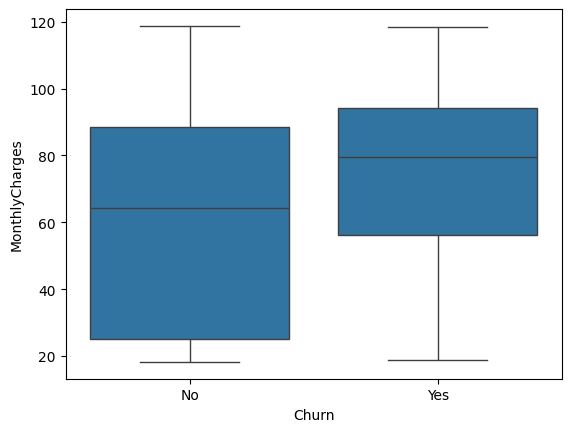

In [160]:
# Monthly Charge Distribution (Box Plot)
sns.boxplot(x='Churn', y='MonthlyCharges', data=churn_data)
plt.show()

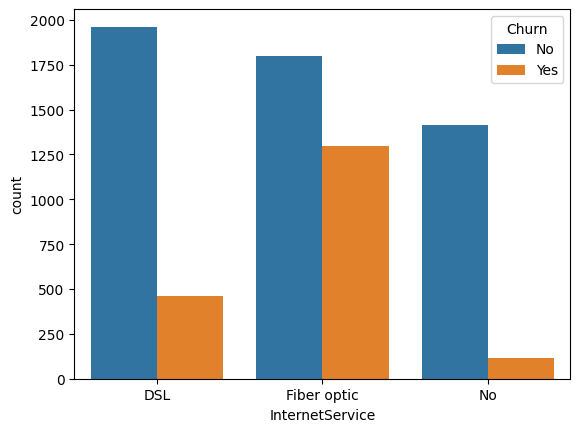

In [161]:
# Internet Service v/s. Churn
sns.countplot(x='InternetService', hue='Churn', data=churn_data)
plt.show()

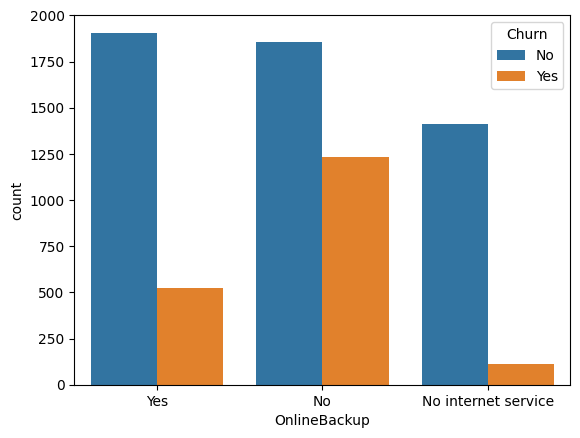

In [162]:
# Add-on Service v/s. Churn
sns.countplot(x='OnlineBackup', hue='Churn', data=churn_data)
plt.show()

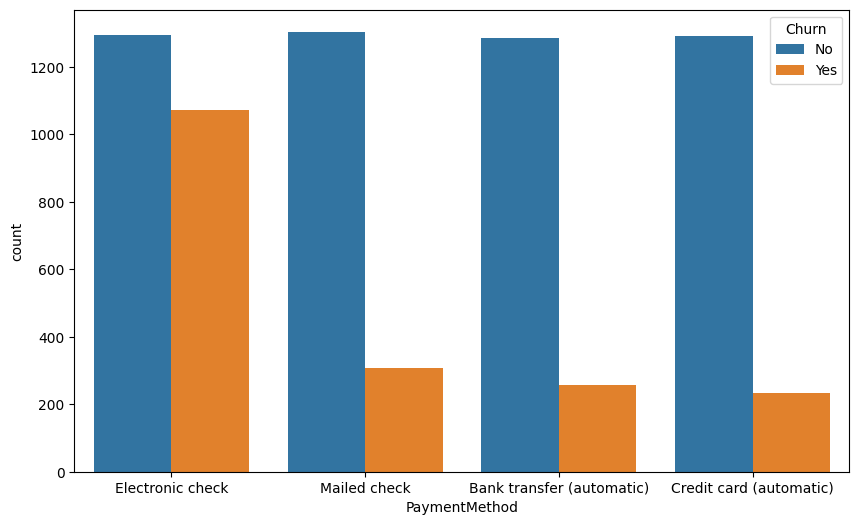

In [163]:
# Payment Method v/s. Churn
plt.figure(figsize=(10,6))
sns.countplot(x='PaymentMethod', hue='Churn', data=churn_data)
plt.show()

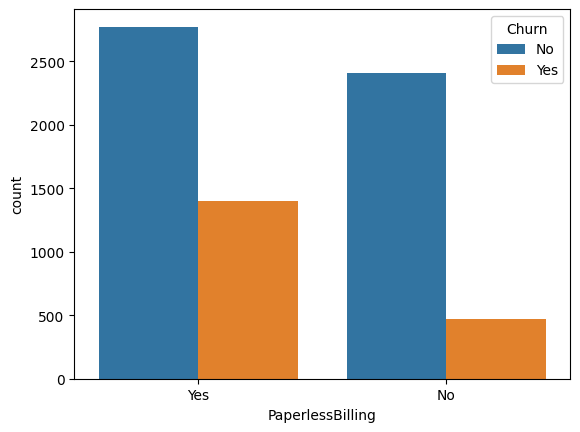

In [164]:
# Paperless Billing v/s. Churn
sns.countplot(x='PaperlessBilling', hue='Churn', data=churn_data)
plt.show()

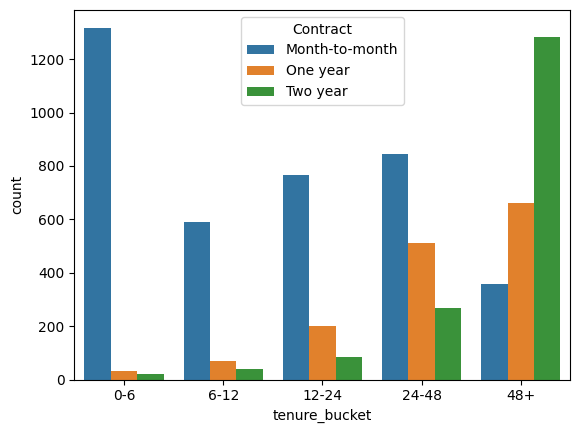

In [165]:
# Tenure Buckets x Contracts
sns.countplot(x='tenure_bucket', hue='Contract', data=churn_data)
plt.show()

**EDA Conclusion**

> Churn is highest among month-to-month and early-tenure customers, especially those with fiber optic service, paperless billing, or paying via electronic check, while long-term contracts and add-on services help reduce churn.



# **Feature Engineering**

> *Turn business intuition into model power by creating features that capture churn signals identified in EDA.*



In [166]:
# Tenure Based Features (early v/s. mid v/s. mature customers)
bins = [0, 6, 12, 24, 48, 100]
labels = ['0-6', '6-12', '12-24', '24-48', '48+']
churn_data['tenure_bucket'] = pd.cut(churn_data['tenure'], bins=bins, labels=labels, right=False)
churn_data['early_tenure'] = (churn_data['tenure'] <= 6).astype(int)

In [167]:
# Encode Contract based on types
churn_data['month_to_month'] = (churn_data['Contract'] == 'Month-to-month')
churn_data['one_year'] = (churn_data['Contract'] == 'One year')
churn_data['two_year'] = (churn_data['Contract'] == 'Two year')

In [168]:
# Services/Add-ons to Binary Variables
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in service_cols:
    churn_data[col] = churn_data[col].map({'Yes': 1, 'No': 0})

churn_data['total_services'] = churn_data[service_cols].sum(axis=1)

In [169]:
# Paperless Billing to binary
churn_data['paperless_billing'] = churn_data['PaperlessBilling'].map({'Yes': 1, 'No': 0})

In [170]:
# Monthly Charges v/s. Average Monthly Charges
avg_monthly = churn_data.groupby('tenure_bucket')['MonthlyCharges'].transform('mean')
churn_data['charges_vs_avg'] = churn_data['MonthlyCharges'] / avg_monthly

/tmp/ipython-input-1003936851.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_monthly = churn_data.groupby('tenure_bucket')['MonthlyCharges'].transform('mean')


In [171]:
# Internet Services One Hot Encoding
churn_data['FiberOptic'] = (churn_data['InternetService'] == 'Fiber optic').astype(int)
churn_data['DSL'] = (churn_data['InternetService'] == 'DSL').astype(int)
churn_data['NoInternet'] = (churn_data['InternetService'] == 'No').astype(int)

In [172]:
# Fill Zeros for the new Columns
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
churn_data[service_cols] = churn_data[service_cols].fillna(0)

In [173]:
# Dropping redundent columns
cols_to_drop = [
    'customerID',          # unique ID, no predictive value
    'gender',              # already captured elsewhere / not engineered
    'Partner',             # already captured in features? or drop if not used
    'Dependents',          # same as above
    'PhoneService',        # drop if you have relevant engineered features
    'MultipleLines',       # drop if you have engineered features
    'InternetService',     # replaced by FiberOptic, DSL, NoInternet
    'PaperlessBilling',    # replaced by paperless_billing (int)
    'TotalCharges',        # string/object, not yet used (can engineer if needed)
    'Contract',            # original categorical column
    'PaymentMethod',        # original, replaced by PaymentMethod_* dummies
    'tenure_bucket'        # replaced by early
]
churn_data.drop(columns=cols_to_drop, inplace=True)

In [174]:
# Map Target Variable
churn_data['Churn'] = churn_data['Churn'].map({'Yes': 1, 'No': 0})

In [175]:
churn_data.dtypes

,0
SeniorCitizen,int64
tenure,int64
OnlineSecurity,float64
OnlineBackup,float64
DeviceProtection,float64
TechSupport,float64
StreamingTV,float64
StreamingMovies,float64
MonthlyCharges,float64
Churn,int64


**Feature Engineering Conclusion**

> The engineered features look clean, business-relevant, and ready for modeling, with tenure, contract type, services, payment behavior, and internet type all capturing key churn signals; the only action needed is to impute missing service values before moving to modeling.




# **Baseline Model**

Goal:

* Show initial predictive power with minimal complexity.

* Identify which features are most important.

* Establish business-relevant metrics like recall on churners.

In [176]:
# Train-test Split
from sklearn.model_selection import train_test_split

x = churn_data.drop(columns='Churn')
y = churn_data['Churn']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [177]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)
y_prob = lr.predict_proba(x_test)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [178]:
# Logistic Regression Performance
from sklearn.metrics import classification_report, roc_auc_score, recall_score, precision_recall_curve

y_pred = (y_prob >= 0.5).astype(int)

print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", round(roc_auc, 4))

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

ROC-AUC Score: 0.8447


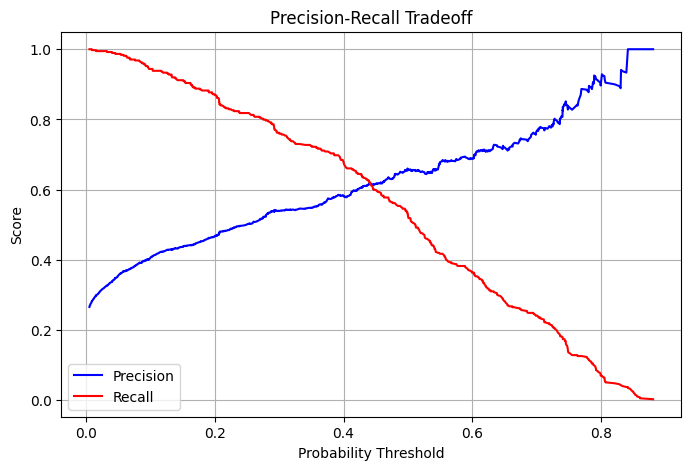

In [179]:
# Precision-Recall Tradeoff
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.grid(True)
plt.show()

**Business takeaway**

* Low threshold: catch more churners (high recall) but annoy safe customers (low precision).

* High threshold: be confident about churners (high precision) but miss some at-risk users (low recall).

* Optimal point: choose a threshold where you balance recall vs precision depending on business cost:

* If retention cost is low, favor higher recall → capture more churners.

* If retention cost is high, favor higher precision → target only the most likely churners.

# **Improved Model: Random Forest**

In [180]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=20, class_weight='balanced')
rf.fit(x_train, y_train)

y_prob = rf.predict_proba(x_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

In [181]:
# Checking metrics
print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", round(roc_auc, 4))

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.51      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.69      1409
weighted avg       0.76      0.77      0.77      1409

ROC-AUC Score: 0.8152


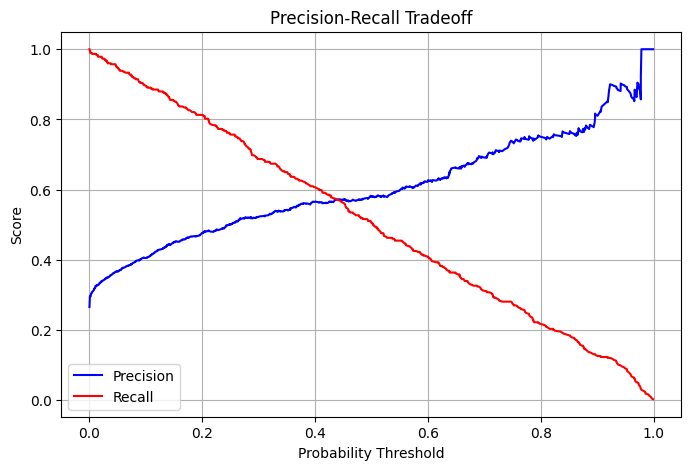

In [182]:
# Precision-Recall Tradeoff
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.grid(True)
plt.show()

**Business Interpretation**

* Random Forest improves recall vs baseline logistic regression (catching more churners).

* Precision tradeoff: We still have false positives, but can tune threshold to focus retention offers on most likely churners.

* Feature importance + probability thresholds can now be used to create risk segmentation → High / Medium / Low churn risk.

In [183]:
# Tuning the Model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=20, class_weight='balanced', min_samples_split=20, min_samples_leaf=10, max_features=1.0)
rf.fit(x_train, y_train)

y_prob = rf.predict_proba(x_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

In [184]:
# Checking metrics
print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", round(roc_auc, 4))

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.73      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409

ROC-AUC Score: 0.8371


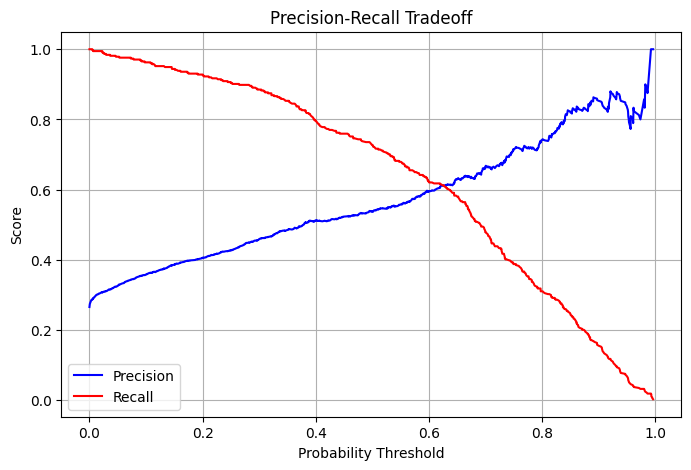

In [185]:
# Precision-Recall Tradeoff
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.grid(True)
plt.show()

In [186]:
high_threshold = 0.7
low_threshold = 0.4

def risk_segment(prob):
    if prob >= high_threshold:
        return 'High Risk'
    elif prob >= low_threshold:
        return 'Medium Risk'
    else:
        return 'Low Risk'

# **Risk Segmentation**

In [187]:
# Apply Segments
risk_segment_test = pd.Series(y_prob, index=x_test.index).apply(risk_segment)
segment_counts = risk_segment_test.value_counts()
print("Customer Counts by Risk Segment (Test Set):")
print(segment_counts)

Customer Counts by Risk Segment (Test Set):
Low Risk       828
Medium Risk    313
High Risk      268
Name: count, dtype: int64


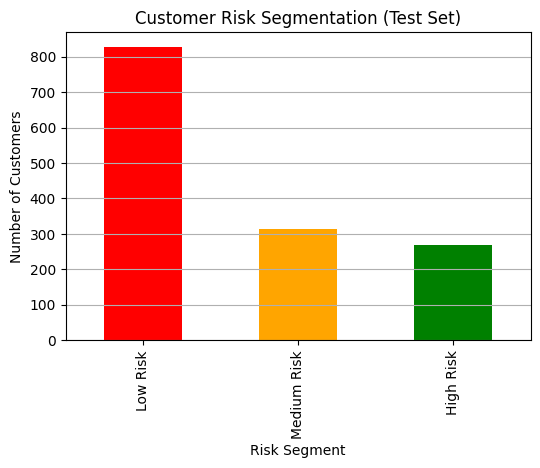

In [188]:
# Plot
plt.figure(figsize=(6,4))
segment_counts.plot(kind='bar', color=['red','orange','green'])
plt.xlabel('Risk Segment')
plt.ylabel('Number of Customers')
plt.title('Customer Risk Segmentation (Test Set)')
plt.grid(axis='y')
plt.show()

In [189]:
# Create a copy to avoid the warning
high_risk_test = x_test[risk_segment_test == 'High Risk'].copy()

# Add actual churn labels
high_risk_test.loc[:, 'Churn'] = y_test.loc[high_risk_test.index]

# Display
print(high_risk_test[['tenure','MonthlyCharges','total_services','month_to_month','Churn']].head(10))


      tenure  MonthlyCharges  total_services  month_to_month  Churn
2280       8          100.15             3.0            True      0
5748      21           99.85             3.0            True      0
3568      21           99.15             4.0            True      0
3524      11           84.80             1.0            True      1
2136      15           91.00             2.0            True      0
6529       2           74.85             0.0            True      1
6125      13          102.25             3.0            True      1
5547       3           89.45             2.0            True      1
346        2           90.40             2.0            True      1
950        2           44.95             0.0            True      1


**Key Insights from Risk Segmentation**

* High-Risk Customers:
  
  * Mostly month-to-month contracts
  * High monthly charges
  * Few or no add-on services (like OnlineSecurity/TechSupport)
  * Early tenure (0–12 months)

* Medium-Risk Customers:
  * Mixed contract types (month-to-month or 1-year)
  * Moderate monthly charges
  * Some services

* Low-Risk Customers:
  * Mostly 2-year contracts
  * Full range of services subscribed
  * Tenure > 24 months

# **Saving for Reports**

**Saving The Model**

In [190]:
# Saving final model
import pickle

with open('final_model.pkl', 'wb') as file:
    pickle.dump(rf, file)

    print("Random Forest model saved as churn_rf_model.pkl")

Random Forest model saved as churn_rf_model.pkl


**Model Summary**

              feature  importance
10     month_to_month    0.412920
15     charges_vs_avg    0.207146
1              tenure    0.134498
8      MonthlyCharges    0.102112
13     total_services    0.020631
14  paperless_billing    0.017503
16         FiberOptic    0.015296
2      OnlineSecurity    0.015011
12           two_year    0.011653
5         TechSupport    0.010854


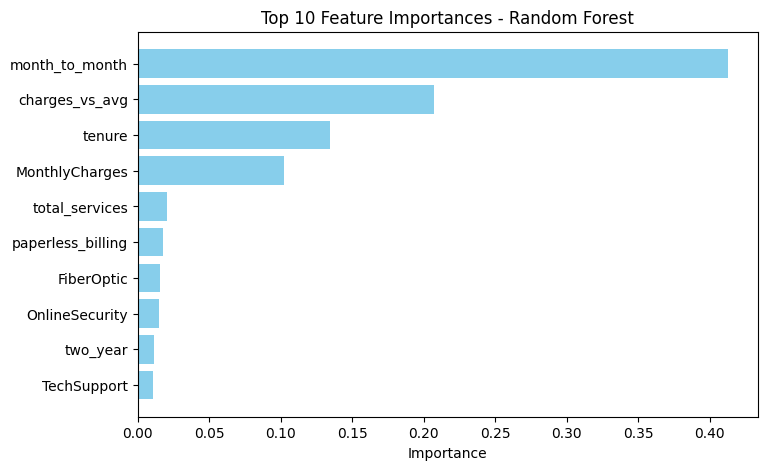

In [193]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Top 10 features
top_features = feature_importance.head(10)
print(top_features)

# Plot
plt.figure(figsize=(8,5))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Random Forest')
plt.show()

**Hyperparameter Summary**

In [194]:
# Random Forest hyperparameters
rf_params = rf.get_params()
print("Random Forest Hyperparameters:")
for key in ['n_estimators','max_depth','min_samples_split','min_samples_leaf','max_features','class_weight','random_state']:
    print(f"{key}: {rf_params[key]}")


Random Forest Hyperparameters:
n_estimators: 500
max_depth: 20
min_samples_split: 20
min_samples_leaf: 10
max_features: 1.0
class_weight: balanced
random_state: 42


In [191]:
# Create a DataFrame with relevant info
risk_df = pd.DataFrame({
    'tenure': x_test['tenure'],
    'MonthlyCharges': x_test['MonthlyCharges'],
    'total_services': x_test['total_services'],
    'month_to_month': x_test['month_to_month'],
    'Churn_actual': y_test,
    'pred_prob': y_prob,
    'risk_segment': risk_segment_test
})

# -----------------------------
# Step 2 — Aggregate metrics per risk segment
# -----------------------------
risk_summary = risk_df.groupby('risk_segment').agg(
    num_customers=('Churn_actual', 'count'),
    avg_tenure=('tenure', 'mean'),
    avg_monthly_charges=('MonthlyCharges', 'mean'),
    avg_total_services=('total_services', 'mean'),
    churn_rate=('Churn_actual', 'mean')
).reset_index()

# Convert churn_rate to percentage
risk_summary['churn_rate'] = (risk_summary['churn_rate'] * 100).round(2)

# Sort by risk level
risk_summary = risk_summary.set_index('risk_segment').loc[['High Risk','Medium Risk','Low Risk']].reset_index()

print(risk_summary)

  risk_segment  num_customers  avg_tenure  avg_monthly_charges  \
0    High Risk            268    9.708955            78.586754   
1  Medium Risk            313   21.172524            69.716294   
2     Low Risk            828   43.164251            57.269022   

   avg_total_services  churn_rate  
0            1.485075       66.79  
1            1.709265       38.02  
2            2.204106        9.18  


In [192]:
risk_summary.to_csv('risk_segmentation_summary.csv', index=False)
print("Risk segmentation table saved as risk_segmentation_summary.csv")

Risk segmentation table saved as risk_segmentation_summary.csv
